# Predicting California Neighborhood Median House Values

## 1. Introduction  
For our project, we will develop a machine-learning model to predict the median house value in California neighborhoods using readily available socioeconomic and geographic attributes (e.g., median income, latitude/longitude, room counts). Accurate and transparent price estimates can assist city planners, nonprofits, and first-time buyers in gauging affordability where up-to-date listing data are sparse. This notebook outlines our data sources, planned modeling workflow, evaluation strategy, and project timeline.

---

## 2. About the Data  

### 2.1 California Housing Prices (1990 Census)  
- **Source:** Kaggle (“California Housing Prices”)  
- **Access:** Download CSV and version-control in our GitHub repo  
- **Size:** 20,640 rows × 10 columns (9 numeric features, 1 categorical)  
- **Target variable:** `median_house_value`  
- **Features:**  
  - **Numeric:** `median_income`, `housing_median_age`, `total_rooms`, `total_bedrooms`, `population`, `households`, `latitude`, `longitude`  
  - **Categorical:** `ocean_proximity`  

**Planned preprocessing:**  
1. Impute missing values in `total_bedrooms`.  
2. Remove or cap extreme outliers in `median_house_value`.  
3. One-hot encode `ocean_proximity`.  
4. Engineer ratio features (e.g., rooms per household).

### 2.2 California Median Household Income (FRED)  
- **Source:** FRED series MEHOINUSCAA646N  
- **Use case:** Used to analyze the affordability trends (not used directly for training).

---

## 3. Methodology Planning  

### 3.1 Feature Engineering  
- **Ratio features:**  
  - `rooms_per_household = total_rooms / households`  
  - `bedrooms_per_room = total_bedrooms / total_rooms`  
- **Interaction terms:** e.g., `median_income × ocean_proximity`  
- **Geographic clustering:** KMeans on `(latitude, longitude)` to capture regional effects  

### 3.2 Modeling Approaches  
1. **Linear models:**  
   - Ordinary Linear Regression (baseline)  
   - Ridge and Lasso (to address multicollinearity)  
2. **Tree-based models:**  
   - Random Forest Regressor  
   - Gradient Boosting Regressor  
3. **Non-parametric baseline:**  
   - k-Nearest Neighbors Regressor  

### 3.3 Hyperparameter Tuning  
- Use `GridSearchCV` with nested cross-validation  
- Optimize for **lowest mean RMSE** on validation folds

---


## 4. Evaluation Plan  

- **Data split:** 80% training / 20% testing  
- **Primary metric:** Root Mean Squared Error (RMSE)  
- **Secondary metric:** Mean Absolute Error (MAE)  
- **Model comparison:** Paired t-tests on cross-validation RMSEs; select best model by statistical significance

---

## 5. Setup and Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

sns.set(style="whitegrid")

# Load datasets
housing = pd.read_csv('housing.csv')
income_fred = pd.read_csv('MEHOINUSCAA646N.csv')

# Quick peek
housing.head(), housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


(   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
 0    -122.23     37.88                41.0        880.0           129.0   
 1    -122.22     37.86                21.0       7099.0          1106.0   
 2    -122.24     37.85                52.0       1467.0           190.0   
 3    -122.25     37.85                52.0       1274.0           235.0   
 4    -122.25     37.85                52.0       1627.0           280.0   
 
    population  households  median_income  median_house_value ocean_proximity  
 0       322.0       126.0         8.3252            452600.0        NEAR BAY  
 1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
 2       496.0       177.0         7.2574            352100.0        NEAR BAY  
 3       558.0       219.0         5.6431            341300.0        NEAR BAY  
 4       565.0       259.0         3.8462            342200.0        NEAR BAY  ,
 None)

## 6. Exploratory Data Analysis (EDA)

Before we begin modeling, let us go through and explore the dataset:

1. Check for any remaining missing values.  
2. Visualize distributions of key features.  
3. Examine correlations.  
4. Map prices geographically.

# 6.1 Check for missing values

In [3]:
print("Missing values per column:")
print(housing.isnull().sum())

Missing values per column:
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


# 6.2 Distribution of key features

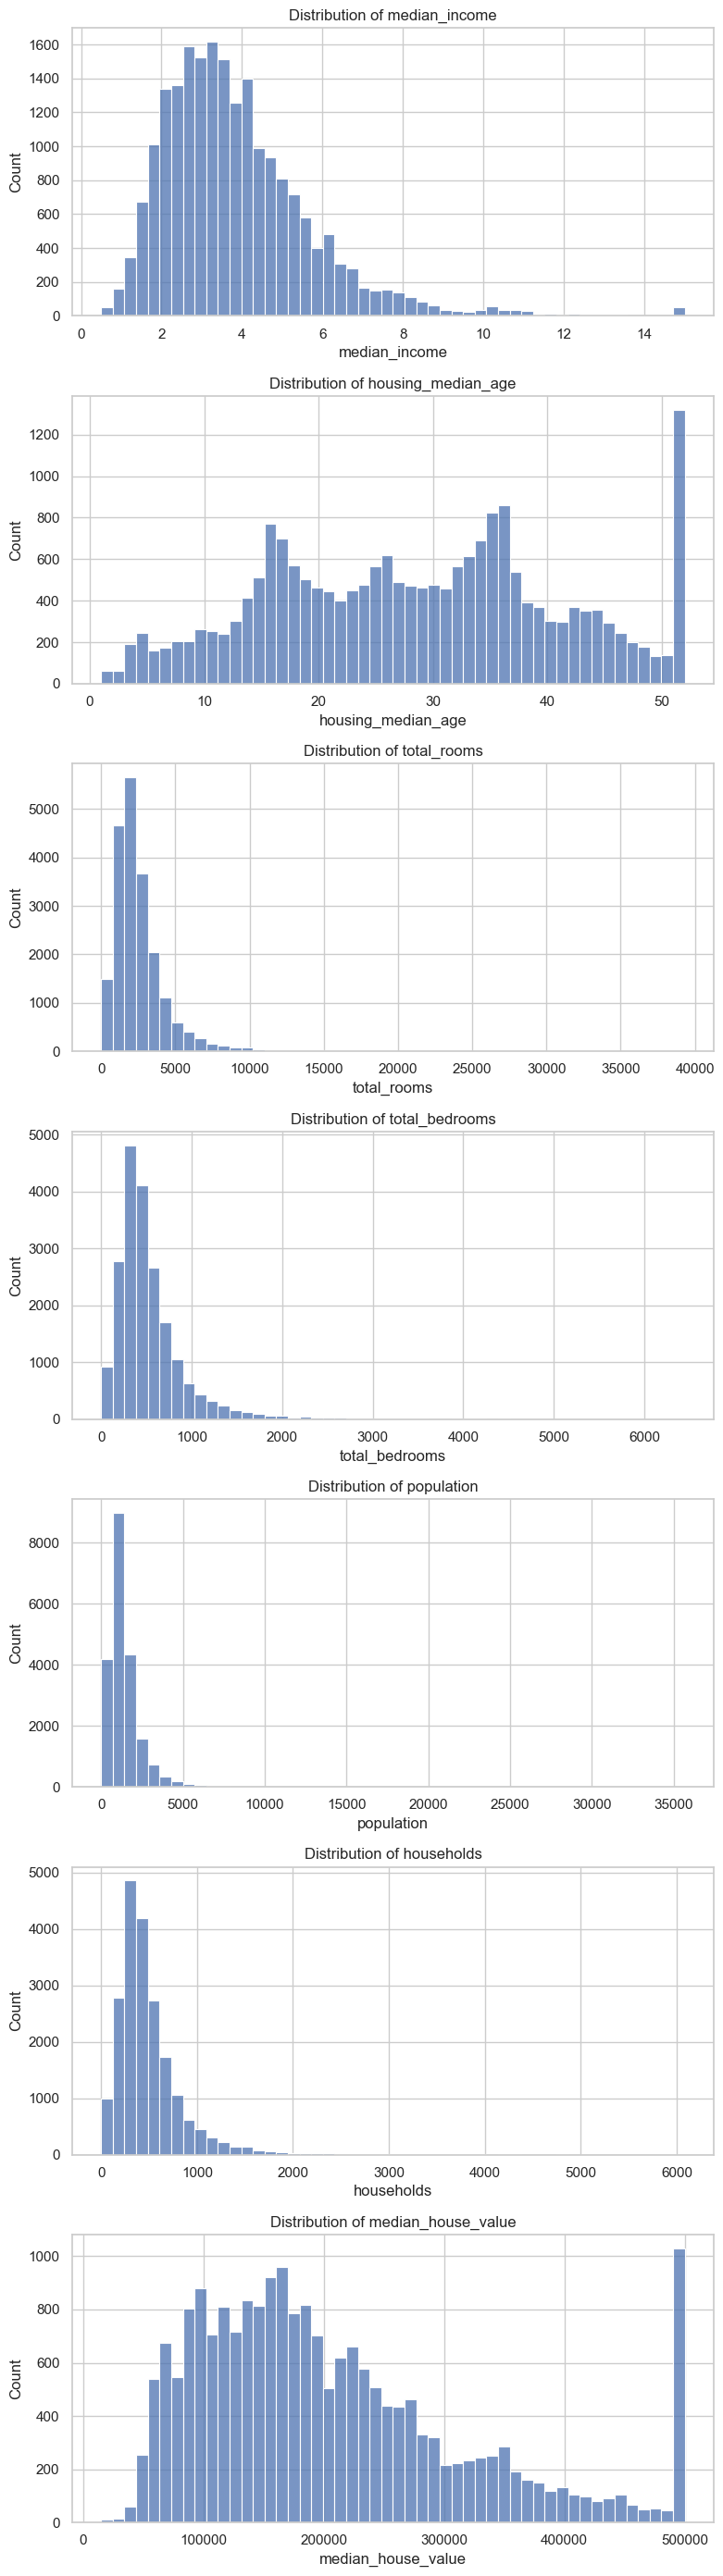

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_feats = [
    'median_income', 'housing_median_age', 'total_rooms',
    'total_bedrooms', 'population', 'households', 'median_house_value'
]

fig, axes = plt.subplots(len(numeric_feats), 1, figsize=(8, 4 * len(numeric_feats)))
for ax, col in zip(axes, numeric_feats):
    sns.histplot(housing[col], bins=50, ax=ax)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
plt.tight_layout()
plt.show()

# 6.3 Correlation heatmap

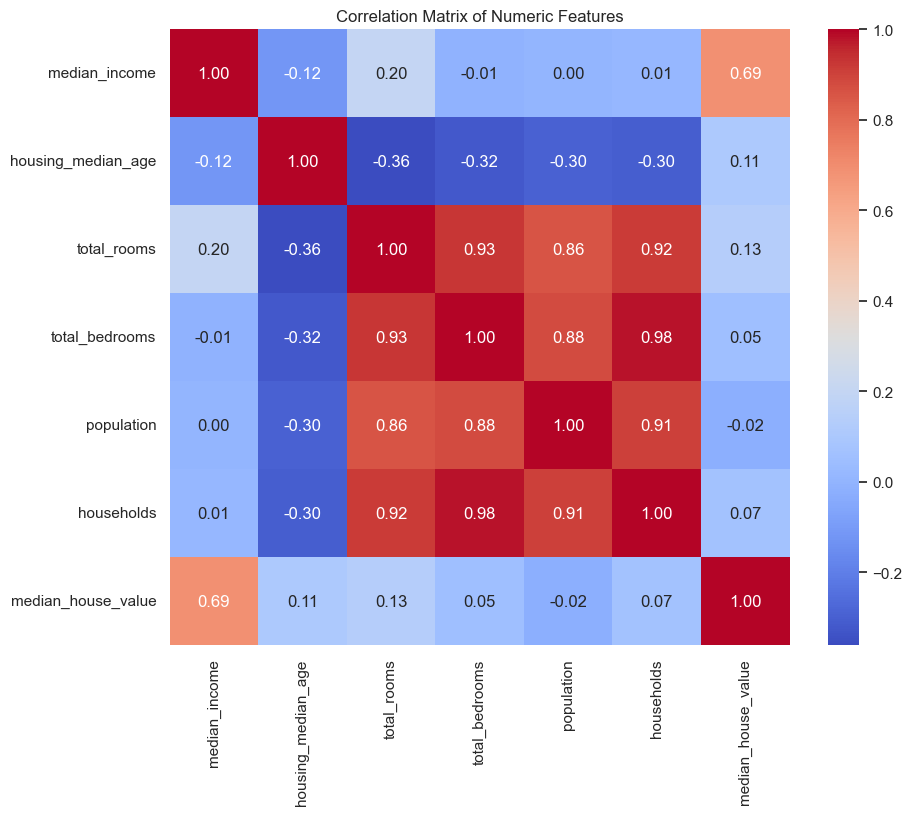

In [7]:
corr = housing[numeric_feats].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

# 7.4 Geographic scatter plot of house prices

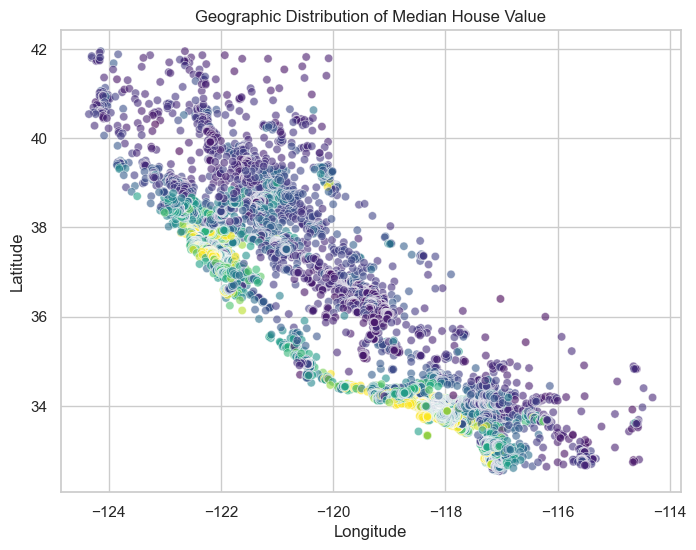

In [9]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='longitude', y='latitude',
    hue='median_house_value',
    palette='viridis', data=housing,
    legend=False, alpha=0.6
)
plt.title('Geographic Distribution of Median House Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## *Observations:* 
- **Missing values**: ***STILL NEEDS TO BE WORKED ON***
- **Distributions**: ***STILL NEEDS TO BE WORKED ON***  
- **Correlations**: ***STILL NEEDS TO BE WORKED ON*** 
- **Geography**: ***STILL NEEDS TO BE WORKED ON***

## 8. Handle Missing Values & Feature Engineering

We saw that `total_bedrooms` has 207 missing entries. We'll impute these with the median. Then we’ll create our ratio features.

# 8.1 Impute missing total_bedrooms with the median

In [11]:
median_bedrooms = housing['total_bedrooms'].median()
housing['total_bedrooms'] = housing['total_bedrooms'].fillna(median_bedrooms)

print("Missing after imputation:\n", housing.isnull().sum())

Missing after imputation:
 longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64


# 8.2 Create ratio features

In [13]:
housing['rooms_per_household']      = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room']        = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

housing[['rooms_per_household','bedrooms_per_room','population_per_household']].head()

,rooms_per_household,bedrooms_per_room,population_per_household
0,6.984127,0.146591,2.555556
1,6.238137,0.155797,2.109842
2,8.288136,0.129516,2.802260
3,5.817352,0.184458,2.547945
4,6.281853,0.172096,2.181467


## 9. Preprocessing Pipeline

Define  pipelines for numeric and categorical features, then combine with a ColumnTransformer.

In [15]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_features = [
    'median_income','housing_median_age','total_rooms','total_bedrooms',
    'population','households','latitude','longitude',
    'rooms_per_household','bedrooms_per_room','population_per_household'
]
cat_features = ['ocean_proximity']

# Numeric pipeline: impute (already done) + scale
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Categorical pipeline: one-hot encode
cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

## 10. Train/Test Split

Split the dataset into training and testing sets (80/20).

In [17]:
from sklearn.model_selection import train_test_split

X = housing.drop('median_house_value', axis=1)
y = housing['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set:", X_train.shape, y_train.shape)
print("Test set:    ", X_test.shape, y_test.shape)

Training set: (16512, 12) (16512,)
Test set:     (4128, 12) (4128,)
